In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir("../")
print("Current working directory:", os.getcwd())

Current working directory: /home/ec2-user/workspace/loce


## Optimize 

In [2]:
from loce import LoCEOptimizationEngineMSCOCO, TorchCustomLoCEBatchOptimizer, LoCEActivationsTensorExtractor
from loce import yolo5_propagator_builder, mobilenet_propagator_builder, efficientnet_propagator_builder
from loce import detr_propagator_builder, vit_propagator_builder, swin_propagator_builder  


# "network_tag": (propagator_builder, processor) dictionary, processor is only needed for DETR, see implementation of corresponding builder
prop_builders = {
        #"detr": detr_propagator_builder,
        #"vit": vit_propagator_builder,
        #"swin": swin_propagator_builder,
        "efficientnet": efficientnet_propagator_builder,
        #"mobilenet": mobilenet_propagator_builder,
       # "yolo": yolo5_propagator_builder,
    }


n_samples_per_category = 100
out_dir = "./experiment_outputs/optimized_loces_coco/"

def optimize():

    imgs_path = f"./data/mscoco2017val/val2017/"
    annots = f"./data/mscoco2017val/annotations/instances_val2017.json"
    processed_annots = f"./data/mscoco2017val/processed/"

    for prop_tag, prop_builder in prop_builders.items():

        if prop_tag == 'detr':
            prop, processor = prop_builder()
        else:
            prop = prop_builder()
            processor = None

        activations_extractor = LoCEActivationsTensorExtractor(prop, prop_tag, processor=processor)
        batch_optimizer = TorchCustomLoCEBatchOptimizer()
        optimizer = LoCEOptimizationEngineMSCOCO(batch_optimizer, activations_extractor, imgs_path, annots, processed_annots, out_base_dir=out_dir, n_imgs_per_category=n_samples_per_category)
        
        optimized_categories = list(optimizer.mscoco_tags.values())
        print(f"Optimizing {prop_tag.upper()}: {', '.join(optimized_categories)}")
        
        optimizer.run_optimization('original')

optimize()

/home/ec2-user/workspace/venvs/python_xai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ec2-user/workspace/venvs/python_xai/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ec2-user/workspace/venvs/python_xai/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currentl

Optimizing EFFICIENTNET: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe


100%|██████████| 19/19 [24:41<00:00, 77.95s/it]


## Check Optimization Stats

In [3]:
from loce import LoCEMultilayerStorageStats, LoCEExperimentConstants

model_tag = "efficientnet"
segmentation_type = "original"

loce_dir = os.path.join(out_dir, f"loce_{segmentation_type}_{model_tag}")

print("OPTIMIZATION STATS (in layers), each column has 2 values: (left) 'failures' part of optimization failures, (right) 'IoU' mean IoU of optimization (LoCE mask vs original segmentation).")

stats = LoCEMultilayerStorageStats(loce_dir)
stats.print_stats(LoCEExperimentConstants.MSCOCO_CATEGORIES_ALL)

OPTIMIZATION STATS (in layers), each column has 2 values: (left) 'failures' part of optimization failures, (right) 'IoU' mean IoU of optimization (LoCE mask vs original segmentation).
Category         &    f.4.2      &     f.5.0      &     f.5.1      &     f.5.2      &     f.6.0      &     f.6.1      &     f.6.2      &     f.7.0    
    person (100) & 0.04    0.60  &  0.00    0.65  &  0.01    0.65  &  0.00    0.66  &  0.01    0.64  &  0.01    0.63  &  0.01    0.63  &  0.02    0.56
   bicycle (100) & 0.20    0.40  &  0.02    0.48  &  0.04    0.49  &  0.04    0.50  &  0.04    0.46  &  0.07    0.45  &  0.07    0.44  &  0.10    0.34
       car (100) & 0.14    0.43  &  0.01    0.47  &  0.01    0.49  &  0.01    0.50  &  0.05    0.45  &  0.06    0.45  &  0.08    0.44  &  0.09    0.39
motorcycle (100) & 0.04    0.59  &  0.00    0.63  &  0.00    0.64  &  0.01    0.65  &  0.03    0.64  &  0.03    0.64  &  0.02    0.64  &  0.03    0.56
  airplane ( 97) & 0.01    0.62  &  0.00    0.62  &  0.00    

## Visualize

Failed optimization of LoCEs for category 9 in layer features.7.0 of efficientnet, where (top) red is LoCE projection and (bottom) green is original segmentation.


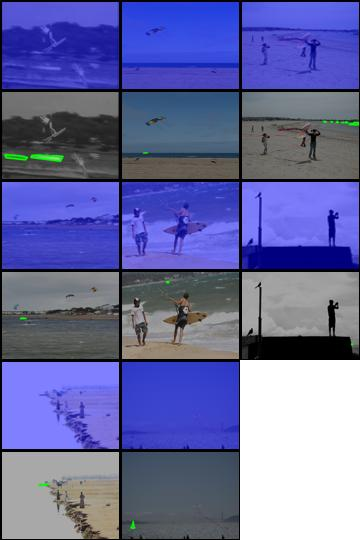

Correct optimization of LoCEs for category 9 in layer features.7.0 of efficientnet, where (top) red is LoCE projection and (bottom) green is original segmentation.


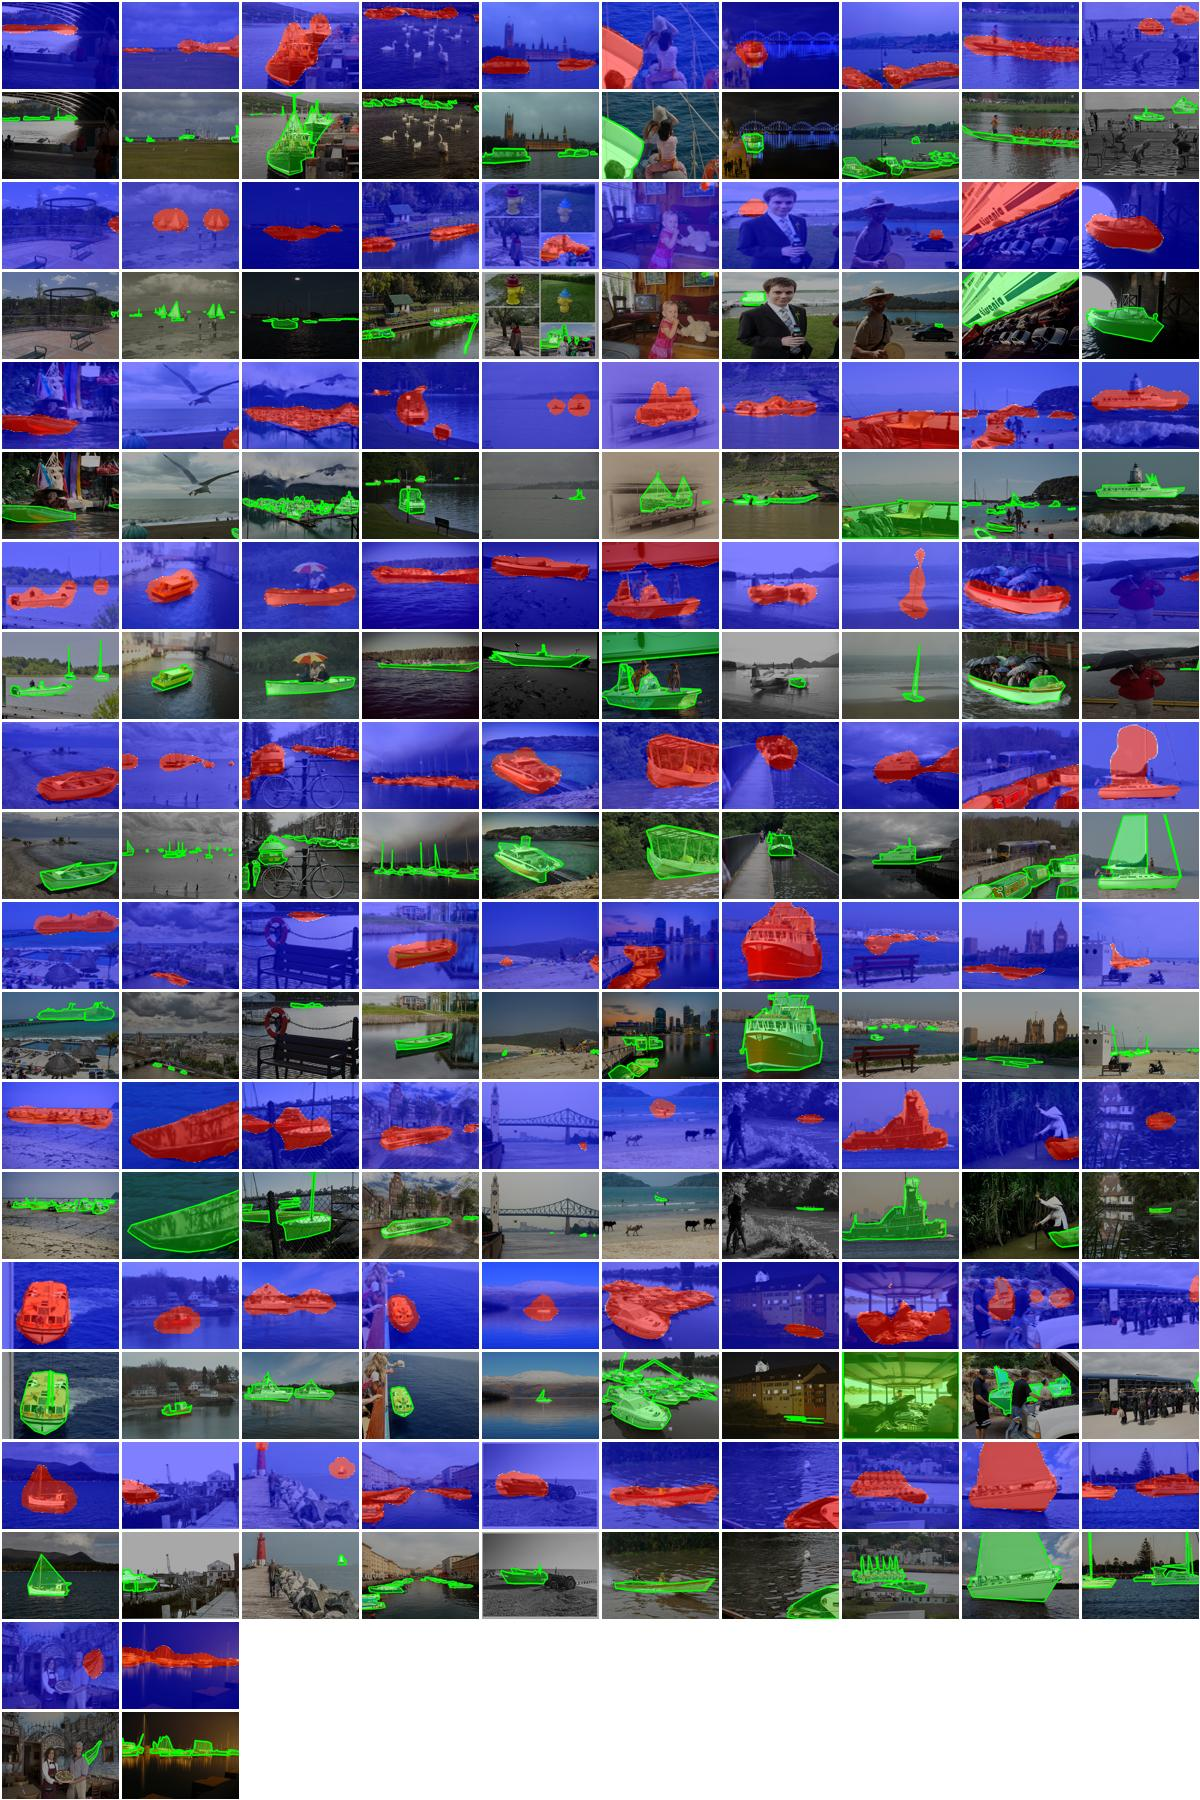

In [4]:
%matplotlib inline

from PIL import Image

from loce import LoCEMultilayerStorageVisuals


category_id = 9  # MS COCO boat
layer = "features.7.0"

loce_vis = LoCEMultilayerStorageVisuals(loce_dir)

loce_vis.visuals([category_id], "./experiment_outputs/visuals/", model_tag, image_tile_size=(120, 90), frame_width=2, layers=[layer])


try:
    image_incorrect = Image.open(os.path.join(f"./experiment_outputs/visuals/{model_tag}", f"incorrect_{category_id}_{layer}.jpg"))
    print(f"Failed optimization of LoCEs for category {category_id} in layer {layer} of {model_tag}, where (top) red is LoCE projection and (bottom) green is original segmentation.")
    image_incorrect.show()
except FileNotFoundError:
    print("No failed optimization found.")


image_correct = Image.open(os.path.join(f"./experiment_outputs/visuals/{model_tag}", f"correct_{category_id}_{layer}.jpg"))

print(f"Correct optimization of LoCEs for category {category_id} in layer {layer} of {model_tag}, where (top) red is LoCE projection and (bottom) green is original segmentation.")
image_correct.show()